In [1]:
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import datetime
from datetime import datetime as dt
#from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split,GridSearchCV, TimeSeriesSplit,RandomizedSearchCV, ParameterGrid
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import SelectKBest, f_classif
from lightgbm.sklearn import LGBMRegressor
#from sklearn.ensemble import RandomForestRegressor
import scipy.sparse as sp
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error,make_scorer
from pdpbox import pdp, get_dataset, info_plots
from sklearn.pipeline import Pipeline
from scipy.sparse import vstack
from pdpbox import pdp, info_plots
seed=11

/Users/dwight/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('data/historical_data.csv')
test_data = pd.read_csv('data/predict_data.csv')

In [3]:
data.head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.0,0.0,0.0,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900,1.0,1.0,2.0,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900,6.0,6.0,9.0,650.0


In [4]:
data.shape

(197428, 9)

In [5]:
test_data.head()

,market_id,created_at,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id
0,3.0,2015-02-25 02:22:30,5477,7500,4.0,4.0,4.0,670.0,194096
1,3.0,2015-02-25 01:14:19,5477,7100,4.0,1.0,1.0,446.0,236895
2,4.0,2015-02-22 02:27:44,5477,4500,9.0,7.0,6.0,504.0,190868
3,3.0,2015-02-25 01:32:39,5477,1700,3.0,3.0,3.0,687.0,183076
4,1.0,2015-02-24 05:20:45,2841,3150,4.0,4.0,4.0,528.0,186200


In [6]:
test_data.shape

(54778, 9)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   subtotal                                      197428 non-null  int64  
 5   total_onshift_dashers                         181166 non-null  float64
 6   total_busy_dashers                            181166 non-null  float64
 7   total_outstanding_orders                      181166 non-null  float64
 8   estimated_store_to_consumer_driving_duration  196902 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 

In [8]:
data['created_at'] = pd.to_datetime(data['created_at'], format = '%Y-%m-%d %H:%M:%S', errors='coerce')
test_data['created_at'] = pd.to_datetime(test_data['created_at'], format = '%Y-%m-%d %H:%M:%S', errors='coerce')
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'], format = '%Y-%m-%d %H:%M:%S', errors='coerce')

In [9]:
data['created_date'] = data['created_at'].dt.date
created_cnt = data.groupby('created_date')['store_id'].count().reset_index().sort_values(by='created_date')
test_data['created_date'] = test_data['created_at'].dt.date
test_created_cnt = test_data.groupby('created_date')['store_id'].count().reset_index().sort_values(by='created_date')

In [10]:
created_cnt

,created_date,store_id
0,2014-10-19,1
1,2015-01-21,2088
2,2015-01-22,6001
3,2015-01-23,6611
4,2015-01-24,8230
5,2015-01-25,7934
6,2015-01-26,5478
7,2015-01-27,5524
8,2015-01-28,5669
9,2015-01-29,6038


In [11]:
test_created_cnt

,created_date,store_id
0,2015-02-18,2388
1,2015-02-19,6775
2,2015-02-20,7512
3,2015-02-21,9987
4,2015-02-22,9466
5,2015-02-23,8081
6,2015-02-24,6344
7,2015-02-25,4225


In [12]:
### drop the 2014-10-19
data = data[data['created_at'].dt.year >= 2015].copy()

In [13]:
# if we don't know actual_delivery_time, we cannot use it for training
data = data.dropna(subset=['actual_delivery_time'])

In [14]:
### based on the train and test slice date and the description, 
### the time is UTC and we would like to convert to US/Pacific

In [15]:
data['created_at'] = data['created_at'].dt.tz_localize("UTC").dt.tz_convert('US/Pacific').dt.tz_localize(None)
test_data['created_at'] = test_data['created_at'].dt.tz_localize("UTC").dt.tz_convert('US/Pacific').dt.tz_localize(None)
data['actual_delivery_time'] = data['actual_delivery_time'].dt.tz_localize("UTC").dt.tz_convert('US/Pacific').dt.tz_localize(None)
# create target variable
data['target'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197420 entries, 0 to 197427
Data columns (total 11 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196433 non-null  float64       
 1   created_at                                    197420 non-null  datetime64[ns]
 2   actual_delivery_time                          197420 non-null  datetime64[ns]
 3   store_id                                      197420 non-null  int64         
 4   subtotal                                      197420 non-null  int64         
 5   total_onshift_dashers                         181159 non-null  float64       
 6   total_busy_dashers                            181159 non-null  float64       
 7   total_outstanding_orders                      181159 non-null  float64       
 8   estimated_store_to_consumer_driving_duration  196894 n

In [17]:
### EDA

In [18]:
data.describe()

,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,target
count,196433.000000,197420.000000,197420.000000,181159.000000,181159.000000,181159.000000,196894.000000,197420.000000
mean,2.978710,3530.581248,2682.331380,44.806866,41.738787,58.047969,545.357766,2865.131294
std,1.524876,2053.498629,1823.109519,34.525913,32.145163,52.660056,219.354328,1613.285907
min,1.000000,1.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,101.000000
25%,2.000000,1686.000000,1400.000000,17.000000,15.000000,17.000000,382.000000,2104.000000
50%,3.000000,3592.000000,2200.000000,37.000000,34.000000,41.000000,544.000000,2660.000000
75%,4.000000,5299.000000,3395.000000,65.000000,62.000000,85.000000,702.000000,3381.000000
max,6.000000,6987.000000,27100.000000,171.000000,154.000000,285.000000,2088.000000,373879.000000


In [19]:
test_data.describe()

,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id
count,54528.000000,54778.000000,54778.000000,50145.000000,50145.000000,50145.000000,54767.000000,54778.000000
mean,3.031360,3489.640969,2715.758772,49.076179,43.515206,62.566756,547.765406,126118.103454
std,1.531606,2050.221801,1897.919808,37.594714,34.051339,56.378953,220.459715,72683.611935
min,1.000000,2.000000,0.000000,-1.000000,-4.000000,-9.000000,0.000000,20.000000
25%,2.000000,1661.000000,1420.000000,19.000000,16.000000,19.000000,385.000000,62938.500000
50%,3.000000,3518.000000,2220.000000,41.000000,36.000000,45.000000,544.000000,126194.000000
75%,4.000000,5247.000000,3415.000000,71.000000,63.000000,91.000000,703.000000,188916.000000
max,6.000000,6986.000000,29925.000000,175.000000,169.000000,292.000000,1550.000000,252031.000000


### some data which doesn't make sense eg. negative total_onshift_dashers,total_busy_dashers,total_outstanding_orders

In [20]:
data[data['total_onshift_dashers'] <0].shape

(21, 11)

In [21]:
data[data['total_busy_dashers'] <0].shape

(21, 11)

In [22]:
data[data['total_outstanding_orders'] <0].shape

(44, 11)

In [23]:
test_data[test_data['total_onshift_dashers'] <0].shape

(2, 10)

In [24]:
test_data[test_data['total_busy_dashers'] <0].shape

(10, 10)

In [25]:
test_data[test_data['total_outstanding_orders'] <0].shape

(13, 10)

### Train data and test data both have negative number. First I wil reach out to the data engineering team why this happend. 
### For this case becasue I still need to provide prediction for the test data. therefore even if these number don't make sense, I suspect there is some reason behind it.
### eg. customer used coupon or dashers are overloading. This could be a feature and also prevent model fail to predict for the test data
### the feature engineering part will cover this

In [26]:
print('min date: ',data['created_at'].min())

min date:  2015-01-21 07:22:03


In [27]:
print('max date: ',data['created_at'].max())

max date:  2015-02-17 22:00:44


In [28]:
print('test min date: ',test_data['created_at'].min())

test min date:  2015-02-18 06:50:28


In [29]:
print('test max date: ',test_data['created_at'].max())

test max date:  2015-02-24 21:59:49


In [30]:
set(data.columns) - set(test_data.columns)

{'actual_delivery_time', 'target'}

In [31]:
set(test_data.columns) - set(data.columns)

{'delivery_id'}

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197420 entries, 0 to 197427
Data columns (total 11 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196433 non-null  float64       
 1   created_at                                    197420 non-null  datetime64[ns]
 2   actual_delivery_time                          197420 non-null  datetime64[ns]
 3   store_id                                      197420 non-null  int64         
 4   subtotal                                      197420 non-null  int64         
 5   total_onshift_dashers                         181159 non-null  float64       
 6   total_busy_dashers                            181159 non-null  float64       
 7   total_outstanding_orders                      181159 non-null  float64       
 8   estimated_store_to_consumer_driving_duration  196894 n

In [33]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54778 entries, 0 to 54777
Data columns (total 10 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   market_id                                     54528 non-null  float64       
 1   created_at                                    54778 non-null  datetime64[ns]
 2   store_id                                      54778 non-null  int64         
 3   subtotal                                      54778 non-null  int64         
 4   total_onshift_dashers                         50145 non-null  float64       
 5   total_busy_dashers                            50145 non-null  float64       
 6   total_outstanding_orders                      50145 non-null  float64       
 7   estimated_store_to_consumer_driving_duration  54767 non-null  float64       
 8   delivery_id                                   54778 non-null  int6

In [34]:
data[['target']].describe()

,target
count,197420.000000
mean,2865.131294
std,1613.285907
min,101.000000
25%,2104.000000
50%,2660.000000
75%,3381.000000
max,373879.000000


In [35]:
print('median: ',data['target'].median())
print('mean: ',data['target'].mean())
print('mode: ',data['target'].mode())
print('positive skew')

median:  2660.0
mean:  2865.131293688583
mode:  0    2483.0
dtype: float64
positive skew


### remove target outlier by IQR

In [36]:
# becaasue the target must be always non negative and it's also positive skewed
# therefore I appplied with log transform
data['log_target'] = np.log(data['target'])

lower bound:  17.214536433312002
upper bound:  114.78709719088786


<AxesSubplot:xlabel='log_target', ylabel='Density'>

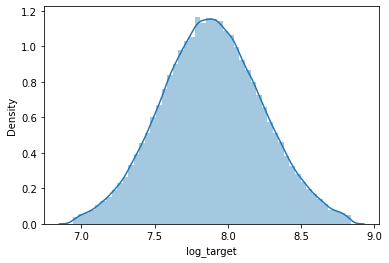

In [37]:
# Applied with IQR
Q1 = data['log_target'].quantile(0.25)
Q3 = data['log_target'].quantile(0.75)
IQR = Q3 - Q1
data = data[~ ( (data['log_target'] < (Q1 - 1.5 * IQR)) | (data['log_target'] > (Q3 + 1.5 * IQR)))]
print('lower bound: ',np.exp(Q1 - 1.5 * IQR)/60)
print('upper bound: ',np.exp(Q3 + 1.5 * IQR)/60)
sns.distplot(data['log_target'])

In [38]:
### seasonality check 
data['created_at_date'] = data['created_at'].dt.date
created_cnt = data.groupby('created_at_date')['store_id'].count().reset_index().sort_values(by='created_at_date')

In [39]:
test_data['created_at_date'] = test_data['created_at'].dt.date
test_created_cnt = test_data.groupby('created_at_date')['store_id'].count().reset_index().sort_values(by='created_at_date')

In [40]:
total = pd.concat([created_cnt, test_created_cnt])

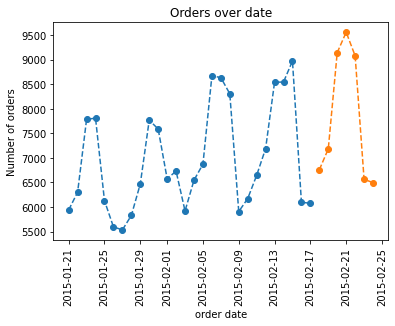

In [41]:
# remove 2014-10-19	 data
#created_cnt = created_cnt[(created_cnt['created_at_date'] > date(2015,1,1)) & (created_cnt['created_at_date'] < date(2015,2,18))]
t = total['created_at_date']
sales = total['store_id']
past = t <= date(2015,2,17)
future = t >= date(2015,2,18)
plt.plot(t[past], sales[past],'o--')
plt.plot(t[future], sales[future],'o--')
#plt.plot(total['created_at_date'], total['store_id'],'o--')
plt.title('Orders over date')
plt.xlabel('order date')
plt.ylabel('Number of orders')
plt.xticks(rotation=90)
plt.show()

In [42]:
print('Cardinality Check')
print('store_id: ',data['store_id'].nunique())

Cardinality Check
store_id:  6732


In [43]:
## it seems like one store_id has multiple market_id, I assume probably this is a franchise.
test_data['delivery_id'].nunique()

54768

In [44]:
### it seems like the duplicate id is due to the realtime features 
### such as total_onshift_dashers,total_busy_dashers,total_outstanding_orders
ids = test_data["delivery_id"]
test_data[ids.isin(ids[ids.duplicated()])].sort_values(by="delivery_id")

,market_id,created_at,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id,created_date,created_at_date
38909,4.0,2015-02-21 15:20:00,6255,1295,37.0,37.0,42.0,373.0,39677,2015-02-21,2015-02-21
38905,4.0,2015-02-21 15:20:00,6255,1295,38.0,36.0,41.0,373.0,39677,2015-02-21,2015-02-21
45728,1.0,2015-02-18 21:10:01,3969,2935,3.0,3.0,5.0,489.0,44340,2015-02-19,2015-02-18
45723,1.0,2015-02-18 21:10:01,3969,2935,3.0,3.0,3.0,489.0,44340,2015-02-19,2015-02-18
49698,2.0,2015-02-21 18:35:00,4829,4898,141.0,141.0,276.0,665.0,63138,2015-02-22,2015-02-21
49686,2.0,2015-02-21 18:35:00,4829,4898,143.0,141.0,273.0,665.0,63138,2015-02-22,2015-02-21
44913,5.0,2015-02-22 17:15:01,1895,2277,20.0,14.0,20.0,342.0,113422,2015-02-23,2015-02-22
44910,5.0,2015-02-22 17:15:01,1895,2277,21.0,15.0,19.0,342.0,113422,2015-02-23,2015-02-22
15432,2.0,2015-02-18 17:45:02,768,3008,88.0,68.0,77.0,394.0,116041,2015-02-19,2015-02-18
15438,2.0,2015-02-18 17:45:02,768,3008,91.0,68.0,77.0,394.0,116041,2015-02-19,2015-02-18


In [45]:
test_data.columns

Index(['market_id', 'created_at', 'store_id', 'subtotal',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', 'delivery_id',
       'created_date', 'created_at_date'],
      dtype='object')

In [46]:
# Fro the cuplicated data, I keep the last one
clean_test_data = test_data.drop_duplicates(subset=['market_id', 'created_at', 'store_id', 'subtotal',
       'estimated_store_to_consumer_driving_duration', 'delivery_id',
       'created_at_date'],keep='last')

In [47]:
clean_test_data.shape # match with uniqueness of delivery_id 

(54768, 11)

### feature engineering

In [48]:
data['created_date'] = data['created_at'].dt.date
data['day_of_week'] = data['created_at'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
data['hours'] = data['created_at'].dt.hour
data['is_holiday'] = np.where(data['created_at'].dt.date == date(2015,2,16),1,0)

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195139 entries, 0 to 197427
Data columns (total 17 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     194166 non-null  float64       
 1   created_at                                    195139 non-null  datetime64[ns]
 2   actual_delivery_time                          195139 non-null  datetime64[ns]
 3   store_id                                      195139 non-null  int64         
 4   subtotal                                      195139 non-null  int64         
 5   total_onshift_dashers                         179064 non-null  float64       
 6   total_busy_dashers                            179064 non-null  float64       
 7   total_outstanding_orders                      179064 non-null  float64       
 8   estimated_store_to_consumer_driving_duration  194616 n

In [50]:
### Usually missing feature is pretty predictive, and the negative number is not random 
### therefore I map null to -1, negative number to -2, the reason 
### which would work well with the tree based model I am going to use later

In [51]:
data['total_onshift_dashers'] = np.where(data['total_onshift_dashers'] < 0, -2, data['total_onshift_dashers'])
data['total_onshift_dashers'].fillna(-1, inplace=True)
data['total_busy_dashers'] = np.where(data['total_busy_dashers'] < 0, -2, data['total_busy_dashers'])
data['total_busy_dashers'].fillna(-1, inplace=True)
data['total_outstanding_orders'] = np.where(data['total_outstanding_orders'] < 0, -2, data['total_outstanding_orders'])
data['total_outstanding_orders'].fillna(-1, inplace=True)

In [52]:
## I create two feature: dasher_busy_ratio & order_dasher_ratio
## again if negative map to -2, null map to -1

In [53]:
data['dasher_busy_ratio'] = data['total_busy_dashers']/data['total_onshift_dashers']
data['order_dasher_ratio'] = data['total_outstanding_orders']/data['total_onshift_dashers']
data['dasher_busy_ratio'] = np.where( (data['total_onshift_dashers'] < 0) | (data['total_busy_dashers'] < 0) | (data['total_outstanding_orders'] < 0), -2, data['dasher_busy_ratio'])
data['order_dasher_ratio'] = np.where( (data['total_onshift_dashers'] < 0) | (data['total_busy_dashers'] < 0) | (data['total_outstanding_orders'] < 0), -2, data['order_dasher_ratio'])
data['dasher_busy_ratio'].fillna(-1,inplace=True)
data['order_dasher_ratio'].fillna(-1,inplace=True)

In [54]:
# there is a divied by zero error
print(data['order_dasher_ratio'].min())
print(data['order_dasher_ratio'].max())
print(data['dasher_busy_ratio'].min())
print(data['dasher_busy_ratio'].max())

-2.0
inf
-2.0
inf


In [55]:
data['market_id'].fillna('missing', inplace=True)
data['market_id'] = data['market_id'].astype(str)
data['store_id'] = data['store_id'].astype(str)
data['estimated_store_to_consumer_driving_duration'].fillna(-1, inplace=True)

In [56]:
data.replace([np.inf], -1, inplace=True)

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195139 entries, 0 to 197427
Data columns (total 19 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     195139 non-null  object        
 1   created_at                                    195139 non-null  datetime64[ns]
 2   actual_delivery_time                          195139 non-null  datetime64[ns]
 3   store_id                                      195139 non-null  object        
 4   subtotal                                      195139 non-null  int64         
 5   total_onshift_dashers                         195139 non-null  float64       
 6   total_busy_dashers                            195139 non-null  float64       
 7   total_outstanding_orders                      195139 non-null  float64       
 8   estimated_store_to_consumer_driving_duration  195139 n

In [58]:
data = data.sort_values(by=['created_at']).reset_index()

### Based on the information provided in the guide, 
### underestimating delivery time is roughly twice as costly as overestimating it. 
### Orders that are very early / late are also much worse than those that are only slightly early / late
### Therefore I customize a asymmetric squared error and loss function
### square error in order to penalize large error
### 2 times penalty for underprediction -> 4 for square error

In [59]:
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*residual, -2*4*residual)
    hess = np.where(residual<0, 2, 4.0*2)
    return grad, hess

def custom_asymmetric_eval(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, residual**2, (residual**2)*4.0) 
    return "custom_asymmetric_eval", np.mean(loss), False
# Create custom metric
def custom_metric(y_test, y_pred):
    # Calculate r-squared score
    i = 0
    res = 0
    for tf in y_test > y_pred:
        if tf:
            res += 4*((y_test.values[i] - y_pred[i])**2)
        else:
            res += ((y_test.values[i] - y_pred[i])**2)
        i += 1

    # Return r-squared score
    return -res/i
cus_scorer = make_scorer(custom_metric)

In [60]:
def process_df(data1, data2, feat_start_date, feat_end_date, target_start_date, target_end_date):
    data1_feat = data1[(data1['created_date'] >= feat_start_date) & (data1['created_date'] <= feat_end_date)]
    data1_target = data2[(data2['created_date'] >= target_start_date) & (data2['created_date'] <= target_end_date)]
    #data1_target['next_week'] = np.where(data1_target['created_date'] == target_end_date,1,0)
    #market, time of day
    data1_target['prev_avg_target_per_market'] = data1_target['market_id'].map(data1_feat.groupby(['market_id'])['target'].mean().to_dict())
    data1_target['prev_avg_target_per_market'].fillna(-1,inplace=True)
    # store
    dct = data1_feat.groupby(by=['market_id','store_id'])['target'].mean().to_dict()
    data1_target['prev_avg_target_per_store_market'] = data1_target.set_index(['market_id', 'store_id']).index.map(dct.get)
    data1_target['prev_avg_target_per_store_market'].fillna(-1,inplace=True)
    data1_target['prev_avg_target_per_store'] = data1_target['store_id'].map(data1_feat.groupby(['store_id'])['target'].mean().to_dict())
    data1_target['prev_avg_target_per_store'].fillna(-1,inplace=True)
    # time of day
    data1_target['prev_avg_target_per_hours'] = data1_target['hours'].map(data1_feat.groupby(['hours'])['target'].mean().to_dict())
    data1_target['prev_avg_target_per_hours'].fillna(-1,inplace=True)
    # day of week
    data1_target['prev_avg_target_per_dow'] = data1_target['day_of_week'].map(data1_feat.groupby(['day_of_week'])['target'].mean().to_dict())
    data1_target['prev_avg_target_per_dow'].fillna(-1,inplace=True)
    ### var
    #market, time of day
    data1_target['prev_var_target_per_market'] = data1_target['market_id'].map(data1_feat.groupby(['market_id'])['target'].var(ddof=0).to_dict())
    data1_target['prev_var_target_per_market'].fillna(-1,inplace=True)
    # store
    dct = data1_feat.groupby(by=['market_id','store_id'])['target'].var(ddof=0).to_dict()
    data1_target['prev_var_target_per_store_market'] = data1_target.set_index(['market_id', 'store_id']).index.map(dct.get)
    data1_target['prev_var_target_per_store_market'].fillna(-1,inplace=True)
    data1_target['prev_var_target_per_store'] = data1_target['store_id'].map(data1_feat.groupby(['store_id'])['target'].var(ddof=0).to_dict())
    data1_target['prev_var_target_per_store'].fillna(-1,inplace=True)
    # time of day
    data1_target['prev_var_target_per_hours'] = data1_target['hours'].map(data1_feat.groupby(['hours'])['target'].var(ddof=0).to_dict())
    data1_target['prev_var_target_per_hours'].fillna(-1,inplace=True)
    return data1_target

In [61]:
(feat_start_date, feat_end_date) = (date(2015,1,21),date(2015,1,27))
(target_start_date, target_end_date) = (date(2015,1,28),date(2015,2,3))
data1_target = process_df(data, data,feat_start_date, feat_end_date, target_start_date, target_end_date)
(feat_start_date, feat_end_date) = (date(2015,1,28),date(2015,2,3))
(target_start_date, target_end_date) = (date(2015,2,4),date(2015,2,10))
data2_target = process_df(data, data, feat_start_date, feat_end_date, target_start_date, target_end_date)
(feat_start_date, feat_end_date) = (date(2015,2,4),date(2015,2,10))
(target_start_date, target_end_date) = (date(2015,2,11),date(2015,2,17))
data3_target = process_df(data, data, feat_start_date, feat_end_date, target_start_date, target_end_date)

In [62]:
data1_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46877 entries, 45094 to 91970
Data columns (total 29 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   index                                         46877 non-null  int64         
 1   market_id                                     46877 non-null  object        
 2   created_at                                    46877 non-null  datetime64[ns]
 3   actual_delivery_time                          46877 non-null  datetime64[ns]
 4   store_id                                      46877 non-null  object        
 5   subtotal                                      46877 non-null  int64         
 6   total_onshift_dashers                         46877 non-null  float64       
 7   total_busy_dashers                            46877 non-null  float64       
 8   total_outstanding_orders                      46877 non-null  

In [63]:
# numerical
num_cols = ['subtotal',
'total_onshift_dashers', 'total_busy_dashers',
'total_outstanding_orders', 
'estimated_store_to_consumer_driving_duration',
# feature engineering
'day_of_week', 'is_weekend', 'hours','is_holiday']
# categorical
one_hot_cat_cols = ['market_id']
bin_cat_cols = ['store_id']
agg_cols = ['prev_avg_target_per_market', 'prev_avg_target_per_store_market','prev_avg_target_per_hours']
           #, 'prev_avg_target_per_store'
            #,'prev_avg_target_per_dow']
           #,'prev_var_target_per_market', 'prev_var_target_per_store_market','prev_var_target_per_hours'
           #, 'prev_var_target_per_store']
            #,'prev_avg_target_per_market_two', 'prev_avg_target_per_store_market_two','prev_avg_target_per_hours_two']
cat_cols = bin_cat_cols + one_hot_cat_cols

In [64]:
select_cols = num_cols+agg_cols+cat_cols
X_1 = data1_target[select_cols]
y_1 = data1_target['target']
X_2 = data2_target[select_cols]
y_2 = data2_target['target']
X_3 = data3_target[select_cols]
y_3 = data3_target['target']

# Feature Selection

In [65]:
frames = [X_1, X_2, X_3]
X = pd.concat(frames)
v = DictVectorizer()
v.fit(X.to_dict('records')) 
X_1_2 = pd.concat([X_1, X_2])
X_train = v.transform(X_1_2.to_dict('records'))
X_test = v.transform(X_3.to_dict('records'))
y_train = np.append(y_1, y_2)
y_test = y_3
best_score = np.inf
for k_cols in [3000, 4000, 5000]:
    selectors = SelectKBest(f_classif, k=k_cols).fit(X_train, y_train)
    X_train_s = X_train[:,selectors.get_support()].copy()
    X_test_s = X_test[:,selectors.get_support()].copy()
    lgbm = LGBMRegressor(random_state=seed, objective=custom_asymmetric_objective)
    lgbm.fit(X_train_s, y_train)
    pred = lgbm.predict(X_test_s)
    score = -custom_metric(y_test,pred)
    if best_score > score:
        best_score = score
        best_k = k_cols
        best_index = selectors.get_support()
        mean_score = mean_squared_error(y_test,pred)
    print(k_cols,score)
print('--------------------------------')    
print(best_k,best_score, mean_score)    

3000 1614417.741224744
4000 1608815.3238152638
5000 1608596.3686866318
--------------------------------
5000 1608596.3686866318 950690.3210181702


# Hyperparameter tuning with customized cross validation, time block randomization in order to avoid network effect

In [66]:
param_grid = {'num_leaves': [30, 50, 70], 'min_child_samples': [10, 20, 30], 
              'max_depth': [10,20,30], 'n_estimators': [300,500,800]
              ,'random_state':[seed], 'objective': [custom_asymmetric_objective] }

best_score = np.inf
X_11 = v.transform(X_1.to_dict('records'))
X_22 = v.transform(X_2.to_dict('records'))
X_33 = v.transform(X_3.to_dict('records'))
XX = [X_11, X_22, X_33]
yy = [y_1, y_2, y_3]
for (ia,ib,ic) in [(0,1,2),(0,2,1),(1,2,0)]:
    for param in list(ParameterGrid(param_grid)):
        lgbm = LGBMRegressor(**param)
        X_train = vstack((XX[ia], XX[ib]))
        y_train = np.append(yy[ia], yy[ib])
        X_test = XX[ic]
        y_test = yy[ic]
        lgbm.fit(X_train[:,best_index], y_train, eval_metric=custom_asymmetric_eval)
        y_pred = lgbm.predict(X_test[:,best_index])
        score = custom_asymmetric_eval(y_test,y_pred)[1]
        if score < best_score:
            best_score = score
            best_param = param
            mean_score = mean_squared_error(y_test,y_pred)
print(best_param, best_score, mean_score)

{'max_depth': 20, 'min_child_samples': 30, 'n_estimators': 800, 'num_leaves': 30, 'objective': <function custom_asymmetric_objective at 0x7fb933e4d200>, 'random_state': 11} 1580783.5868334568 1011269.938230474


In [67]:
X_t = v.transform(X.to_dict('records'))
y_t = np.concatenate([y_1, y_2, y_3], axis=0)
lgbm = LGBMRegressor(**best_param)
lgbm.fit(X_t[:,best_index], y_t, eval_metric=custom_asymmetric_eval)

LGBMRegressor(max_depth=20, min_child_samples=30, n_estimators=800,
              num_leaves=30,
              objective=<function custom_asymmetric_objective at 0x7fb933e4d200>,
              random_state=11)

### feature importance

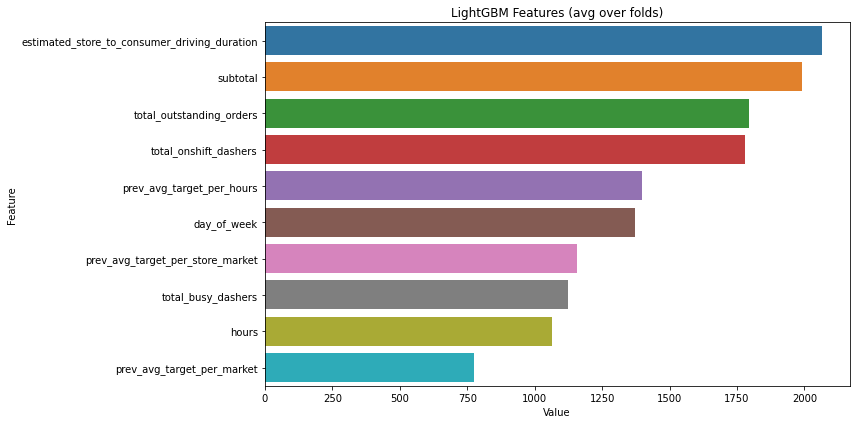

In [68]:
whole_feature_cols = np.array(v.get_feature_names())
selected_feature_cols = whole_feature_cols[best_index]
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, selected_feature_cols)), columns=['Value','Feature'])
plt.figure(figsize=(12, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(10))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

### apply trained model to test data

In [69]:
clean_test_data

,market_id,created_at,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id,created_date,created_at_date
0,3.0,2015-02-24 18:22:30,5477,7500,4.0,4.0,4.0,670.0,194096,2015-02-25,2015-02-24
1,3.0,2015-02-24 17:14:19,5477,7100,4.0,1.0,1.0,446.0,236895,2015-02-25,2015-02-24
2,4.0,2015-02-21 18:27:44,5477,4500,9.0,7.0,6.0,504.0,190868,2015-02-22,2015-02-21
3,3.0,2015-02-24 17:32:39,5477,1700,3.0,3.0,3.0,687.0,183076,2015-02-25,2015-02-24
4,1.0,2015-02-23 21:20:45,2841,3150,4.0,4.0,4.0,528.0,186200,2015-02-24,2015-02-23
...,...,...,...,...,...,...,...,...,...,...,...
54773,1.0,2015-02-20 10:11:18,2956,1088,13.0,11.0,11.0,824.0,174203,2015-02-20,2015-02-20
54774,1.0,2015-02-21 13:01:44,2956,1824,26.0,26.0,32.0,477.0,138333,2015-02-21,2015-02-21
54775,1.0,2015-02-21 10:19:19,2956,2933,10.0,10.0,12.0,318.0,34110,2015-02-21,2015-02-21
54776,1.0,2015-02-19 15:43:26,2956,1438,12.0,12.0,18.0,593.0,178028,2015-02-19,2015-02-19


In [70]:
def preprocess_fill_df(data):
    ## create time feature
    data['created_date'] = data['created_at'].dt.date
    data['day_of_week'] = data['created_at'].dt.dayofweek
    data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
    data['hours'] = data['created_at'].dt.hour
    data['is_holiday'] = np.where(data['created_at'].dt.date == date(2015,2,16),1,0)
    # create ratio and fill up weird and missing number
    data['total_onshift_dashers'] = np.where(data['total_onshift_dashers'] < 0, -2, data['total_onshift_dashers'])
    data['total_onshift_dashers'].fillna(-1, inplace=True)
    data['total_busy_dashers'] = np.where(data['total_busy_dashers'] < 0, -2, data['total_busy_dashers'])
    data['total_busy_dashers'].fillna(-1, inplace=True)
    data['total_outstanding_orders'] = np.where(data['total_outstanding_orders'] < 0, -2, data['total_outstanding_orders'])
    data['total_outstanding_orders'].fillna(-1, inplace=True)
    data['dasher_busy_ratio'] = data['total_busy_dashers']/data['total_onshift_dashers']
    data['order_dasher_ratio'] = data['total_outstanding_orders']/data['total_onshift_dashers']
    data['dasher_busy_ratio'] = np.where( (data['total_onshift_dashers'] < 0) | (data['total_busy_dashers'] < 0) | (data['total_outstanding_orders'] < 0), -2, data['dasher_busy_ratio'])
    data['order_dasher_ratio'] = np.where( (data['total_onshift_dashers'] < 0) | (data['total_busy_dashers'] < 0) | (data['total_outstanding_orders'] < 0), -2, data['order_dasher_ratio'])
    data['dasher_busy_ratio'].fillna(-1,inplace=True)
    data['order_dasher_ratio'].fillna(-1,inplace=True)
    data['market_id'].fillna('missing', inplace=True)
    data['market_id'] = data['market_id'].astype(str)
    data['store_id'] = data['store_id'].astype(str)
    data['estimated_store_to_consumer_driving_duration'].fillna(-1, inplace=True)
    data.replace([np.inf], -1, inplace=True)
    return data

In [71]:
processed_clean_test_data = preprocess_fill_df(clean_test_data)

In [72]:
clean_test_data.head()

,market_id,created_at,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id,created_date,created_at_date,day_of_week,is_weekend,hours,is_holiday,dasher_busy_ratio,order_dasher_ratio
0,3.0,2015-02-24 18:22:30,5477,7500,4.0,4.0,4.0,670.0,194096,2015-02-24,2015-02-24,1,0,18,0,1.000000,1.000000
1,3.0,2015-02-24 17:14:19,5477,7100,4.0,1.0,1.0,446.0,236895,2015-02-24,2015-02-24,1,0,17,0,0.250000,0.250000
2,4.0,2015-02-21 18:27:44,5477,4500,9.0,7.0,6.0,504.0,190868,2015-02-21,2015-02-21,5,1,18,0,0.777778,0.666667
3,3.0,2015-02-24 17:32:39,5477,1700,3.0,3.0,3.0,687.0,183076,2015-02-24,2015-02-24,1,0,17,0,1.000000,1.000000
4,1.0,2015-02-23 21:20:45,2841,3150,4.0,4.0,4.0,528.0,186200,2015-02-23,2015-02-23,0,0,21,0,1.000000,1.000000


In [73]:
(feat_start_date, feat_end_date) = (date(2015,2,11),date(2015,2,17))
(target_start_date, target_end_date) = (date(2015,2,18),date(2015,2,24))
data4_no_target = process_df(data, processed_clean_test_data, feat_start_date, feat_end_date, target_start_date, target_end_date)

In [74]:
X_4 = data4_no_target[select_cols]
X_4_t = v.transform(X_4.to_dict('records'))

In [75]:
test_data_predict = lgbm.predict(X_4_t[:,best_index])

In [76]:
test_data_predict.shape

(54768,)

In [77]:
# prediction QA
print('previous week mean delivery time  true {} pred {}'.format(y_test.mean(), y_pred.mean()))
print('new predicted mean delivery time {}'.format(test_data_predict.mean()))
print('previous week median delivery time  true {} pred {}'.format(y_test.median(), np.median(y_pred)))
print('new predicted median delivery time {}'.format(np.median(test_data_predict)))

previous week mean delivery time  true 2928.3835783006593 pred 3161.801902573401
new predicted mean delivery time 3212.679150146226
previous week median delivery time  true 2730.0 pred 3102.5282556593747
new predicted median delivery time 3163.5500319305875


In [78]:
# first week true delivery time
(feat_start_date, feat_end_date) = (date(2015,1,21),date(2015,1,27))
data1_delivery_time = data[(data['created_date'] >= feat_start_date) & (data['created_date'] <= feat_end_date)]

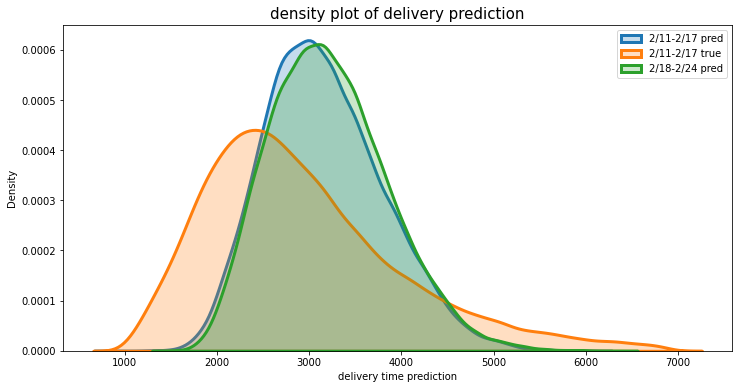

In [79]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.distplot(y_pred , hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, axlabel="delivery time prediction", label = "2/11-2/17 pred")
ax = sns.distplot(y_test , hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, axlabel="delivery time prediction", label = "2/11-2/17 true")
ax = sns.distplot(test_data_predict, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3},  label = "2/18-2/24 pred")
ax.legend()
title = ax.set_title('density plot of delivery prediction', size=15)

### From the plot above, we can aww 2/11-2/17 true is the most right skewed which make senses because we tried to build a model which tried to penalize more on the underprediction that's why our prediction tends to be more overprediction.
### Based on the insight from the orders over date plot, we can infer the volume of orders is increasing over weeks. therefore 
### which the prediction stats is higher than the previous week prediction makes sense to me.

In [80]:
final_data = {'delivery_id':list(data4_no_target['delivery_id']),
        'predicted_duration':list(test_data_predict)}
 
# Creates pandas DataFrame.
final_df = pd.DataFrame(final_data)

In [81]:
final_df.to_csv('data_to_predict.csv',index=False)

In [82]:
frames = [X_1, X_2, X_3]
X = pd.concat(frames)

In [83]:
X.shape

(150045, 14)

In [84]:
y_t

array([5182., 3529., 5646., ..., 2092., 1682., 2926.])

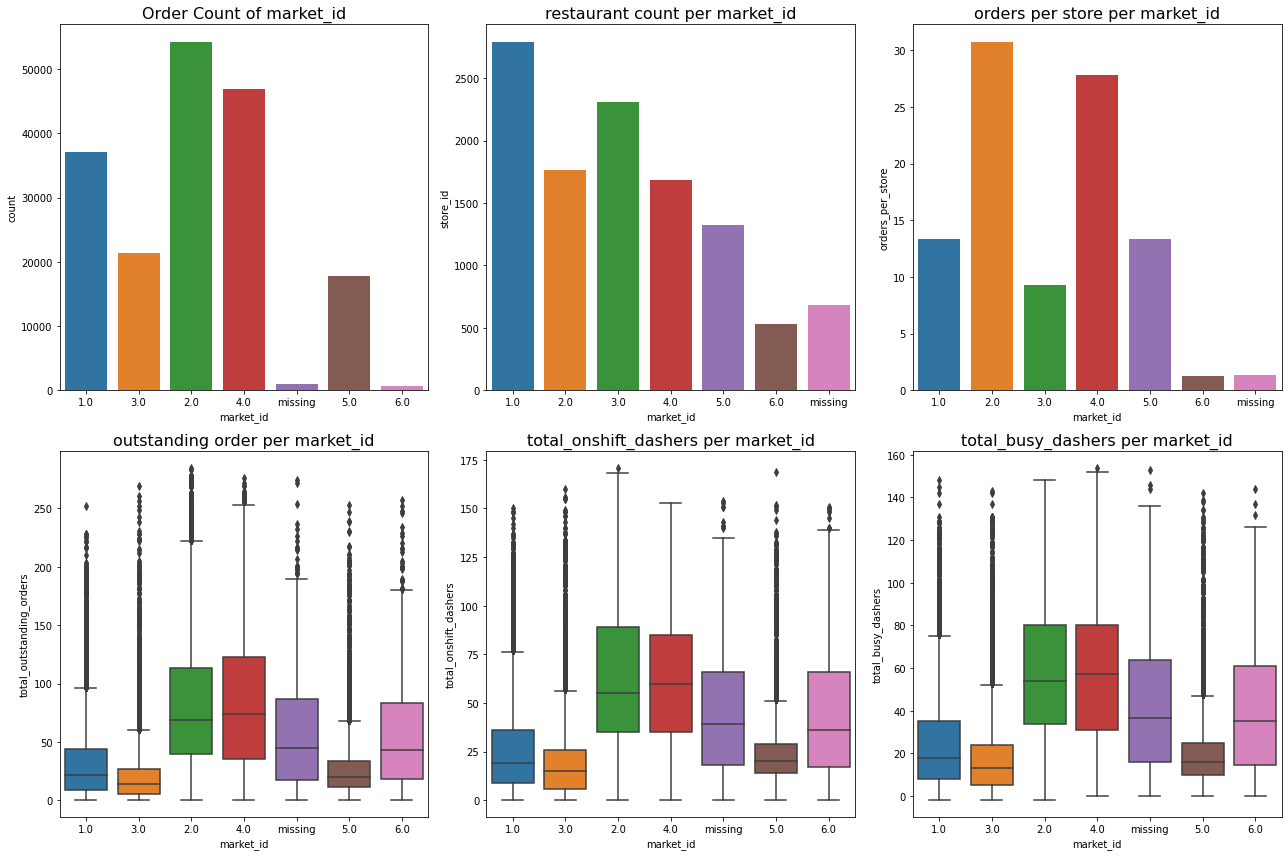

In [85]:
data = data[(data['total_outstanding_orders'] >=0) & (data['total_onshift_dashers'] >= 0)]
# Visualization of different cities
#grouped = data[['market_id', 'target']].groupby('city_name').mean().reset_index()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
sns.countplot(x='market_id', data=data, ax=ax[0][0])
ax[0][0].set_title('Order Count of market_id', fontsize=16)
#ax[0].set_yscale('log')
#sns.boxplot(x='market_id', y='target', data=data, ax=ax[0][1]);
#ax[0][1].set_title('Mean delivery time per market_id', fontsize=16)
grouped = data[['market_id', 'store_id']].groupby('market_id')['store_id'].nunique().reset_index()
sns.barplot(x='market_id', y='store_id', data=grouped, ax=ax[0][1]);
ax[0][1].set_title('restaurant count per market_id', fontsize=16)
grouped = data[['market_id', 'store_id']].groupby('market_id')['store_id'].nunique().reset_index()
grouped2 = data[['market_id', 'created_at']].groupby('market_id')['created_at'].count().reset_index()
gt = grouped.merge(grouped2, on='market_id')
gt['orders_per_store'] = gt['created_at'] / gt['store_id']
sns.barplot(x='market_id', y='orders_per_store', data=gt, ax=ax[0][2]);
ax[0][2].set_title('orders per store per market_id', fontsize=16)
sns.boxplot(x='market_id', y='total_outstanding_orders', data=data, ax=ax[1][0]);
ax[1][0].set_title('outstanding order per market_id', fontsize=16)
sns.boxplot(x='market_id', y='total_onshift_dashers', data=data, ax=ax[1][1]);
ax[1][1].set_title('total_onshift_dashers per market_id', fontsize=16)
sns.boxplot(x='market_id', y='total_busy_dashers', data=data, ax=ax[1][2]);
ax[1][2].set_title('total_busy_dashers per market_id', fontsize=16)
#sns.boxplot(x='market_id', y='estimated_store_to_consumer_driving_duration', data=data, ax=ax[3][1]);
#ax[3][1].set_title('Mean estimated_store_to_consumer_driving_duration per market_id', fontsize=16)
plt.tight_layout()
plt.show()

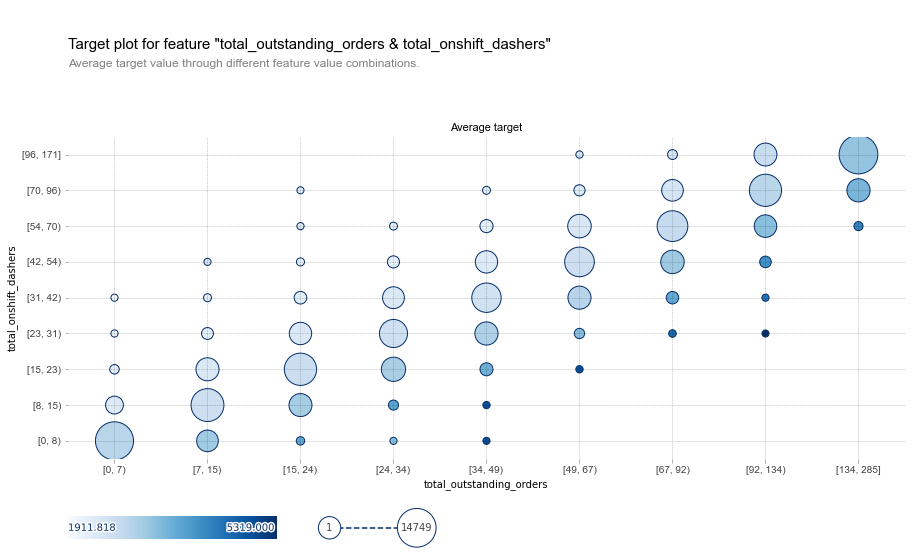

In [86]:
data_clean = data[(data['total_outstanding_orders'] >=0) & (data['total_onshift_dashers'] >= 0)]
fig, axes, summary_df = info_plots.target_plot_interact(
    df=data_clean, features=['total_outstanding_orders', 'total_onshift_dashers'], feature_names=['total_outstanding_orders', 'total_onshift_dashers'], target='target'
)

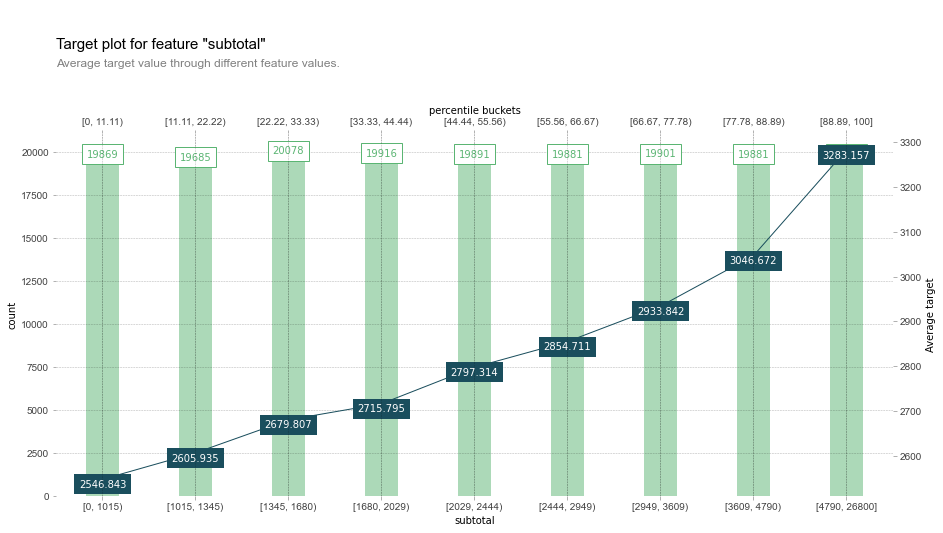

In [87]:
fig, axes, summary_df = info_plots.target_plot(
    df=data_clean, feature='subtotal', feature_name='subtotal', target='target', show_percentile=True
)